<a href="https://colab.research.google.com/github/bksaini078/fake_news_detection/blob/master/MeanTeacher/MT_Synonym_N_Dropouts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Calculating consistency cost with synonym replacement and dropout together.

**Author : Bhupender Kumar Saini**

# Declaring Libraries 





In [ ]:
#please install contractions 
import numpy as np
import re
import nltk
# import contractions
import string
import pandas as pd
import os
import numpy as np

import random

import spacy
import time
import re
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import utils 
from gensim.test.utils import get_tmpfile
from nltk.corpus import stopwords
import nltk
import en_core_web_sm
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from pathlib import Path

# nlp = en_core_web_sm.load()
# nltk.download('stopwords')
# nltk.download('punkt')
# porter=PorterStemmer()


In [ ]:
import tensorflow as tf 

import tensorflow.keras as tfk
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Lambda
from tensorflow.keras.models import Model
import numpy as np
import datetime
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
#this is to enable eager execution
tf.compat.v1.enable_eager_execution()
path = '/content/drive/My Drive/Colab Notebooks/LatestData_July'
# path = '/content/drive/My Drive/Colab Notebooks/lokesh_data'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Tokenization

In [ ]:
def tokenization(x_train, x_test, x_unlabel, maxlen):

    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing import sequence
    import numpy as np

    # max_features = 20000
    # maxlen = 100
    # batch_size = 32

    tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ',
                          char_level=False, oov_token=None, document_count=0)
    full_article = np.hstack((x_train, x_test, x_unlabel))
    tokenizer.fit_on_texts(full_article)
    x_train_token = tokenizer.texts_to_sequences(x_train)
    x_test_token = tokenizer.texts_to_sequences(x_test)
    x_unlabel_token = tokenizer.texts_to_sequences(x_unlabel)
    x_train_seq = sequence.pad_sequences(x_train_token, maxlen=maxlen,padding='post')
    x_test_seq = sequence.pad_sequences(x_test_token, maxlen=maxlen,padding='post')
    x_unlabel_tar= sequence.pad_sequences(x_unlabel_token, maxlen=maxlen,padding='post')
    # defining vocalbury size
    vocab_size = len(tokenizer.word_index) + 1

    x_train = x_train_seq
    x_test = x_test_seq
    return x_train, x_test , x_unlabel_tar, vocab_size, tokenizer

# Noise Creator 

In [ ]:
def instant_noise(x_train, y_train, x_unlabel, n_ratio ):
    '''this function introduce noise in the training data for mean teacher model , 
    this function is used in calculating classification cost, user have to provide 
    amount of noise, want to add(ratio) in train data and test train split ratio too'''
    #amount of noise need to add in x_train data 
    noise=int(np.shape(x_train)[0]*n_ratio)
 
    # taking column of x_train, need it later 
    x_column = np.shape(x_train)[1]

    if noise <= int(np.shape(x_unlabel)[0]):

        #taking number of noise from unlabel data 
        ratio_noise = x_unlabel[:noise]

        # creating -1 label for noise data 
        y_unlabel=np.full((np.shape(ratio_noise)[0], 1), -1)

        # adding noise in train data 
        x = np.append(x_train, ratio_noise, axis=0)
        # print(np.shape(x))
        y = np.append(y_train, y_unlabel, axis=0)
        x = np.append(x,y, axis=1)
        row = np.shape(x)[0]

        # shufflin data 
        x =np.random.permutation(x)
        # print(np.shape(x))

        #seperating label from x 
        y_train_n=np.reshape(x[:,x_column],(row,1))
        x_train_n=x[0:len(x),0:x_column]
        # y_train_n= np.reshape(y[:len(x),0],(train_split,1))

        
    else :
        print('error: Insufficient unlabel data available !')

    return x_train_n, y_train_n


In [ ]:
from tensorflow.keras.preprocessing import sequence
from nltk import WordPunctTokenizer
from gensim.models.fasttext import FastText

def embedding_creation(full_article):
    word_punctuation_tokenizer = nltk.WordPunctTokenizer()
    word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in full_article]
    embedding_size = 60
    window_size = 40
    min_word = 5
    down_sampling = 1e-2
    embedd_model = FastText(word_tokenized_corpus,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=0,
                      iter=50)
    print('Finished and saving model at location', path)
    embedd_model.save(path+'embedding_Model.model')
    return 


def synonym_noise(x_batch,maxlen,tokenizer):
    articles = tokenizer.sequences_to_texts(x_batch)
    changed_articles=[]
    model_embedd= FastText.load( path+'/embedding.model')
    for article in articles:
        word_array= article.split(' ')
        sent1=[]
        '''toss and taking random decision on data'''
        if np.random.binomial(1, 0.4):
            for word in word_array:
                if word in model_embedd.wv.vocab:
                    most_similar=model_embedd.wv.most_similar(word)
                    # print(most_similar[0][0])
                    #flipping coin to decide to change or not if head change word and if tails dont change
                    #change p value for reducing or increasing the edit 
                    if np.random.binomial(1, 0.2):
                        sent1.append(most_similar[0][0])
                    else:
                        sent1.append(word)
                else:
                    sent1.append(word)
            joined_text = ' '.join(sent1)
        else:
            joined_text=' '.join(word_array)
        changed_articles.append(joined_text)
    x_train_seq_n = tokenizer.texts_to_sequences(changed_articles)
    x_train_seq_n = sequence.pad_sequences(x_train_seq_n,maxlen=maxlen)
    # x_train_seq_n=tf.convert_to_tensor(x_train_seq_n)
    return x_train_seq_n
def drop_out(x_batch,probability):
    # print(type(x_batch))
    for i in range(len(x_batch)):
        for j in range(len(x_batch[i])):
            if np.random.binomial(1, probability):
                x_batch[i][j]=0
            else:
                continue
    x_batch_1=tf.convert_to_tensor(x_batch)
    return x_batch_1

# Model Declaration



In [ ]:
def BiLstmModel(maxlen, vocab_size):
  tf.keras.backend.clear_session()
  inputs = keras.Input(shape=(maxlen,))
  x =Embedding(vocab_size, 128, input_length=None)(inputs)
  x =Bidirectional(LSTM(128))(x)
#   x = Dropout(0.2)(x)
#   x =Dense(64,activation='relu')(x)
  x =Dense(2)(x)
  x =Dense(1, activation='sigmoid')(x)
  return Model(inputs,x)


# Evaluation Functions

In [ ]:

#Function to create confusion matrix 
def Confusion_matrix(model,x_test,y_true, threshold, caption='Confusion matrix'):
    '''this function will create confusion matrix with predicted value and true label'''
    y_hat= model.predict(x_test)
    y_pred=(np.greater_equal(y_hat,threshold)).astype(int)
    cm=confusion_matrix(y_true,y_pred)
    # print(cm)
    # calculating recall , precision and f1 score 
    tp_and_fp=np.sum(cm[:,1])
    tn_and_fp=np.sum(cm[0,:])
    tp_and_fn = np.sum(cm[1, : ])
    tp_and_tn= np.trace(cm)
    tp=(tp_and_fp-tn_and_fp+tp_and_tn)/2
    '''handling with divide by zero is pending'''
    #TODO: handling of divide by zero 
    precision=tp/tp_and_fp 
    recall = tp/tp_and_fn
    accuracy= np.trace(cm)/np.sum(cm)
    # f1_score=sklearn.metrics.f1_score(y_true, y_pred)
    f1_score= (2*precision*recall)/(precision+recall)
    print('Precision:', precision)
    print('Recall:', recall)
    print('f1 Score:', f1_score)
    print('Accuracy:', accuracy)

    # import matplotlib.pyplot as plt
    # figure = plt.figure(figsize=(8, 8))
    # # cm=np.around(cm.astype(int))
    # # con_mat_norm = np.around(cm, decimals=4)
    # con_mat_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    # sns.heatmap(con_mat_norm, annot=True,cmap=plt.cm.Oranges)
    # plt.tight_layout()
    # plt.ylabel('True label')
    # plt.xlabel('Predicted label')
    # plt.title(caption)
    
    # plt.show()
    return cm, accuracy, precision, recall, f1_score
def prec_rec_f1score(y_true,x_test,model):
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    bce = tf.keras.losses.BinaryCrossentropy()
    y_hat= model.predict(x_test)
    y_pred=(np.greater_equal(y_hat,0.51)).astype(int)
    pr_re_f1score_perclass= precision_recall_fscore_support(y_true, y_pred, average=None)
    pr_re_f1score_average=precision_recall_fscore_support(y_true, y_pred, average='micro')
    precision=precision_score(y_true,y_pred,average=None)
    recall = recall_score(y_true,y_pred,average=None)
    accuracy= accuracy_score(y_true,y_pred)
    f1_score=f1_score(y_true,y_pred)
    #per class
    precision_true=pr_re_f1score_perclass[0][1]
    precision_fake=pr_re_f1score_perclass[0][0]
    recall_true=pr_re_f1score_perclass[1][1]
    recall_fake=pr_re_f1score_perclass[1][0]
    f1score_true= pr_re_f1score_perclass[2][1]
    f1score_fake= pr_re_f1score_perclass[2][0]
    metrices_name=['accuracy','precision_true','precision_fake','recall_true','recall_fake','f1score_true','f1score_fake']
    metrices_value=[accuracy, precision_true, precision_fake, recall_true, recall_fake, f1score_true, f1score_fake]
    i=0
    for item in metrices_name:
        print(item +':' ,metrices_value[i])
        i+=1
    binary_loss= bce(y_true, y_hat).numpy()
    print('Binary_loss',binary_loss)

    return accuracy, precision_true, precision_fake, recall_true, recall_fake, f1score_true, f1score_fake,binary_loss 


In [ ]:
import matplotlib.pyplot as plt
def scatter_plot(logits, y_t, title):
    marker_size=20
    figure = plt.figure(figsize=(20, 6))
    plt.scatter(logits,logits, marker_size, c=y_t)
    plt.title(title)
    plt.xlabel("Predicted Probability")
    plt.ylabel("Predicted Probability")
    cbar= plt.colorbar()
    cbar.set_label("Probability", labelpad=+1)
    plt.show()
    return

# accuracy 
def model_evaluation(model, x_test, y_true, name):
    y_hat= model(x_test)
    y_pred=(np.greater(y_hat,0.505)).astype(int)
    cm=confusion_matrix(y_true,y_pred)
    
    accuracy= np.trace(cm)/np.sum(cm)
    
    print(name+ ":")
  
    print(' Accuracy:', accuracy)

    # this will plot the result 
    # scatter_plot(y_hat,y_true, title=name)

    return accuracy #precision, recall, f1_score, accuracy
def plot_roc(fpr,tpr,label):
    #  plot the roc curve for the model
    pyplot.plot(fpr, tpr, linestyle='--', label=label)

    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot 
    pyplot.show()
    return

# Cost Functions

In [ ]:
# declaring loss function
# ref:https://github.com/CuriousAI/mean-teacher/tree/master/tensorflow/mean_teacher  updated according to our need .
def classification_costs(logits, labels):
    """ Commputing classification cost , after removing labels -1 of unlabelled data and then calculating 
    the binary cross entropy .
    """
    applicable = tf.not_equal(labels, -1)

     # Change -1s to zeros to make cross-entropy computable
    labels = tf.where(applicable, labels, tf.zeros_like(labels))

    # This will now have incorrect values for unlabeled examples
    per_sample = tf.keras.losses.binary_crossentropy(labels,logits)
    # Retain costs only for labeled
    per_sample = tf.where(applicable, per_sample, tf.zeros_like(per_sample))
    # Take mean over all examples, not just labeled examples.
    # print('sample', np.shape(per_sample))
    loss = tf.math.divide( tf.reduce_mean(tf.reduce_sum(per_sample)), np.shape(per_sample)[0])

    return loss

#custom loss function
def Overall_Cost(classification_cost, consistency_cost, ratio=0.5):
    return (ratio * classification_cost) + ((1 - ratio)*consistency_cost)
#function for consistency cost 
def Consistency_Cost(teacher_output, student_output):
    #Kl divergence 
    # kl = tf.keras.losses.KLDivergence()
    # sq_diff_layer=kl(teacher_output, student_output).numpy()
    
    #MSE
    sq_diff_layer = tf.reduce_mean(tf.math.squared_difference(teacher_output, student_output))
    return sq_diff_layer
def ema(student_model, teacher_model, alpha):
    '''
    Calculates the exponential moving average of the student model weights and updates the teacher model weights
    formula:
    t_i = alpha * t_{i-1} + (1 - alpha) * s_i, with default alpha = 0.99
    t_i = weights of teacher model in current epoch
    s_i = weights of student model in current epoch
    '''
    #taking weights 
    student_weights = student_model.get_weights()
    teacher_weights = teacher_model.get_weights()

    #length must be equal otherwise it will not work 
    assert len(student_weights) == len(teacher_weights), 'length of student and teachers weights are not equal Please check. \n Student: {}, \n Teacher:{}'.format(
        len(student_weights), len(teacher_weights))

    new_layers = []
    for i, layers in enumerate(student_weights):
        new_layer = alpha*(teacher_weights[i]) + (1-alpha)*layers
        new_layers.append(new_layer)
    teacher_model.set_weights(new_layers)
    return teacher_model


# Writing Report

In [ ]:

def report_writing(Model,lr,Batch_Size, Epoch,Alpha,Ratio, train_accuracy,test_accuracy,precision_true,precision_fake,recall_true,recall_fake,f1score_true,f1score_fake,Classification_Loss,comment):
    x = datetime.datetime.now()
    report_df = pd.DataFrame(columns=['Date', 'Model','Learning Rate','Batch_Size', 'Epoch','Alpha','Ratio','Train_Accuracy',
                                      'Test_Accuracy', 'Precision_True','Precision_Fake','Recall_True','Recall_Fake','F1_Score_True','F1_Score_Fake','Classification_Loss',
                                      'comment'])
    report_df = report_df.append({'Date' : x.strftime("%c"), 'Model' :Model,'Learning Rate':lr,'Batch_Size' : Batch_Size, 'Epoch': Epoch,'Alpha': Alpha,'Ratio': Ratio,'Train_Accuracy': train_accuracy,
                                  'Test_Accuracy': test_accuracy, 'Precision_True': precision_true,'Precision_Fake': precision_fake,'Recall_True': recall_true,'Recall_Fake': recall_fake,'F1_Score_True': f1score_true,'F1_Score_Fake': f1score_fake, 'Classification_Loss':Classification_Loss,'comment': comment}, ignore_index=True)
    my_file = Path(path+'/report_synonymanddropout_0.99_10fold_2.csv')

    if my_file.exists():
        report_df.to_csv(path+'/report_synonymanddropout_0.99_10fold_2.csv',mode='a', header= False , index = False)
    else:
        report_df.to_csv(path+'/report_synonymanddropout_0.99_10fold_2.csv',mode='w', header= True , index= False) 
    return 

# report_writing('Supervised-BiLstm', 124,10,34, 0.5, 0.99,0.90,0.90,0.90)

# Loading data 

In [ ]:

def loading_data():
    if not os.path.isfile(path+'/xte_shuffled.npy'):
        print("Please clean the data first or the location of npy file is incorrect, Checking function Loading_data")
    else:
      x_tr = np.load(path+'/xtr_shuffled.npy',allow_pickle=True)
      x_te = np.load(path+'/xte_shuffled.npy',allow_pickle=True)
      y_tr = np.load(path+'/ytr_shuffled.npy',allow_pickle=True)
      y_te = np.load(path+'/yte_shuffled.npy',allow_pickle=True)
      x_un = np.load(path+'/xun_shuffled.npy',allow_pickle=True)
    #   print("train Data_Size:",  np.shape(x_tr))
    #   print("test Data_Size:",  np.shape(x_te))
      


      # Performing Kfold here 
    return x_tr, y_tr, x_te, y_te, x_un


def Kfold_crossvalidation(x_train,y_train,x_test,y_test):
    '''this function is for k_fold crossvalidation implementation'''
    from sklearn.model_selection import train_test_split
    data= np.append(x_train, x_test, axis=0)
    label= np.append(y_train,y_test, axis=0)
    label= np.reshape(label,(len(label),1))
    column_size= np.shape(data)[1]
    # combining whole data
    whole_data=np.append(data,label.astype(int),axis=1)
    whole_data= np.random.permutation(whole_data)
    whole_label= whole_data[:][:,-1:]
    whole_data= whole_data[:][:,:column_size]
    x_tr, x_te, y_tr, y_te = train_test_split(whole_data, whole_label, test_size=0.33)
    return x_tr, y_tr, x_te, y_te

# Supervised Model

In [ ]:


def train_supervised(epochs, batch_size, lr, x_train, y_train, x_test, y_test,maxlen,vocab_size):

    model_supervised = BiLstmModel(maxlen, vocab_size)
    model_supervised.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= lr ),loss= 'binary_crossentropy', metrics=['accuracy'])
    print('Training supervised Model...')
    history=model_supervised.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_split=0.25)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()  

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # evaluation
    train_accuracy=history.history['accuracy'][len(history.epoch)-1]
       
    test_accuracy,precision_true,precision_fake,recall_true,recall_fake,f1score_true,f1score_fake,binary_loss = prec_rec_f1score(y_test,x_test,model_supervised)
    cm, test_accuracy, precision, recall, f1_score =Confusion_matrix(model_supervised,x_test,y_test,0.51, 'Supervised model')
    report_writing('Supervised_BILSTM',lr, batch_size,len(history.epoch),'NaN','NaN', train_accuracy, 
                   test_accuracy, precision_true, precision_fake, recall_true, recall_fake, 
                   f1score_true, f1score_fake,binary_loss,'Baseline')    


# MEAN teacher
In this updation takes place during each step/batch. This model doesnt work 

In [ ]:
def train_MeanTeacher(epochs, batch_size, alpha, lr, ratio,x_train, y_train, x_test, y_test, x_unlabel_tar,vocab_size, tokenizer,maxlen):
    #splitting training data 
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)


    #preparing the training dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    # Prepare the validation dataset.
    # val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    # val_dataset = val_dataset.batch(batch_size)

    #preparing the target dataset 
    tar_dataset =  tf.data.Dataset.from_tensor_slices(x_unlabel_tar)
    tar_dataset = tar_dataset.shuffle(buffer_size=1024).batch(batch_size)

    #declaring optimiser
    optimizer= tf.keras.optimizers.Adam(learning_rate= lr ) #trying changing learning rate , sometimes it gives good result 
    train_metrics = tf.keras.metrics.BinaryAccuracy(name='Binary_Accuracy')
    val_acc_metric = tf.keras.metrics.BinaryAccuracy(name="Binary_Acc")
    teacher_acc_metric = tf.keras.metrics.BinaryAccuracy(name="Binary_Acc_teacher") 
    # Creating model
    student = BiLstmModel(maxlen, vocab_size)
    teacher = BiLstmModel(maxlen, vocab_size)


    # collecting costs
    #this one for collecting the costs
    # consistency=[]
    # overall=[]
    # classification=[]
    train_accuracy=[]
    steps=[]

    # iterator_unlabel = iter(tar_dataset)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    val_dataset = val_dataset.batch(batch_size)

    #training teacher with one epoch 
   
    #this I am doing to get all steps details in epoch
    i=0
    print('Train Mean teacher Model...')
    teacher.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
    teacher.fit(x_train,y_train, batch_size=batch_size, epochs=1)

    acc_t=0
    x_unlabel_tar= tf.convert_to_tensor(x_unlabel_tar)
    #false positive rate and true positive rate
    fpr=[]
    tpr=[]
    for epoch in range(1,epochs+1):  
        print(*"*****************")
        print('Start of epoch %d' % (epoch,))
        print(*"*****************")
        #iteration over batches 
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
             with tf.GradientTape() as tape:
         
                # adding instant noise
                iterator_unlabel = iter(tar_dataset)
                x_batch_unlabel = iterator_unlabel.get_next()

                
                '''this is related to change with synonyms in articles'''
                x_batch_sn= synonym_noise(x_batch_train.numpy(),maxlen,tokenizer)
                x_batch_dp= drop_out(x_batch_sn,0.2)

                

                # Run the forward pass of the layer
                logits= student(x_batch_dp, training= True)  
                

                
                train_metrics(y_batch_train,logits)  

                #Calculating classification cost 
                classification_cost = classification_costs(logits,y_batch_train)
                
         


                x_batch_sn1= synonym_noise(x_batch_train.numpy(),maxlen,tokenizer)
                x_batch_dp1= drop_out(x_batch_sn1,0.2)
                
                # tar_student= student(x_batch_dp1)
                tar_teacher = teacher(x_batch_dp1) #x_batch_train
                
                consistency_cost= Consistency_Cost(tar_teacher,logits) 
                

                overall_cost= Overall_Cost(classification_cost, consistency_cost, ratio=0.5)
              
                #adding loss to student model 
             grads= tape.gradient(overall_cost, student.trainable_weights)
             i=i+1
             steps.append(i)
   
             # the value of the variables to minimize the loss.
             optimizer.apply_gradients(zip(grads, student.trainable_weights))
             teacher= ema(student, teacher, alpha=alpha)

        train_acc = train_metrics.result()
        print(alpha)
   
        #appending training accuracy
        train_accuracy.append(train_acc)

   
        train_metrics.reset_states()
   
        
        print('*******STUDENT*************')
        prec_rec_f1score(y_val,x_val,student)
        print('*******TEACHER*************')
        prec_rec_f1score(y_val,x_val,teacher)

     # evaluation of the model at different epoch 
        if epoch >= 10 and epoch % 5 ==0 :
            print('---------------------------STUDENT--------------------------')
            test_accuracy,precision_true,precision_fake,recall_true,recall_fake,f1score_true,f1score_fake,binary_loss = prec_rec_f1score(y_test,x_test,student)
            report_writing('Student',lr, batch_size,epoch,alpha,ratio, train_acc.numpy(), 
                           test_accuracy, precision_true, precision_fake, recall_true, recall_fake, 
                           f1score_true, f1score_fake,binary_loss,'Synonym and dropout')  
            print('-----------------------------------------------------------------')
    
            print('---------------------------TEACHER---------------------------------')
      
            test_accuracy,precision_true,precision_fake,recall_true,recall_fake,f1score_true,f1score_fake,binary_loss = prec_rec_f1score(y_test,x_test,teacher)
            report_writing('Teacher',lr, batch_size,epoch,alpha,ratio, train_acc.numpy(), 
                           test_accuracy, precision_true, precision_fake, recall_true, recall_fake, 
                           f1score_true, f1score_fake,binary_loss,'Synonym and dropout') 
            print('-----------------------------------------------------------------')
            y_pred = teacher.predict(x_test)
            fpr_, tpr_, _ = roc_curve(y_test, y_pred)
            plot_roc(fpr_,tpr_,'Synonym and dropout')
            fpr.append(fpr_)
            tpr.append(tpr_)
            print('-----------------------------------------------------------------')
# saving this for roc curve
    np.save(path+'/roc/fpr_synonymNdropout',fpr)
    np.save(path+'/roc/tpr_synonymNdropout',tpr)
    tf.keras.backend.clear_session()

    return teacher

    

train Data_Size: (2189, 100)
test Data_Size: (244, 100)
Train Label count: True, Fake 1131 1058
Test Label count : True, Fake 128 116
Train Mean teacher Model...
26/26 [==============================] - 11s 436ms/step - loss: 0.6925 - accuracy: 0.5320
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.5054744525547445
precision_true: 0.5642857142857143
precision_fake: 0.4852941176470588
recall_true: 0.27335640138408307
recall_fake: 0.7644787644787645
f1score_true: 0.3682983682983683
f1score_fake: 0.5937031484257871
Binary_loss 0.6915622
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.4726277372262774
precision_true: 0.0
precision_fake: 0.4726277372262774
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6418835192069392
Binary_loss 0.69223773
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5364963503649635
precision_true: 0.5466666666666666
precision_fake: 0.5144508670520231
recall_true: 0.7093425605536332
recall_fake: 0.3436293436293436
f1score_true: 0.6174698795180723
f1score_fake: 0.41203703703703703
Binary_loss 0.69027245
*******TEACHER*************
accuracy: 0.4726277372262774
precision_true: 0.0
precision_fake: 0.4726277372262774
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6418835192069392
Binary_loss 0.6926072
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5565693430656934
precision_true: 0.5575
precision_fake: 0.5540540540540541
recall_true: 

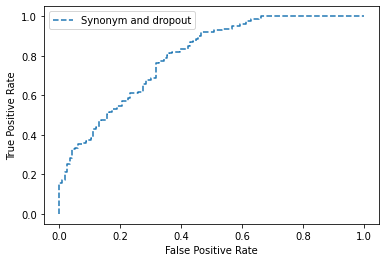

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6824817518248175
precision_true: 0.7346938775510204
precision_fake: 0.6402640264026402
recall_true: 0.6228373702422145
recall_fake: 0.749034749034749
f1score_true: 0.6741573033707865
f1score_fake: 0.6903914590747331
Binary_loss 1.0178485
*******TEACHER*************
accuracy: 0.6058394160583942
precision_true: 0.9101123595505618
precision_fake: 0.5468409586056645
recall_true: 0.28027681660899656
recall_fake: 0.9691119691119691
f1score_true: 0.4285714285714286
f1score_fake: 0.6991643454038997
Binary_loss 0.66310436
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6277372262773723
precision_true: 0.6375404530744336
precision_fake: 0.6150627615062761
recall_true: 0.6816608996539792
recall_fake: 0.5675675675675675
f1score_true: 0.6588628762541806
f1score_fake: 0.5903614457831325
Binary_loss 0.88784045
*******TEACHER*************
accuracy: 0.6131386861313869
precisio

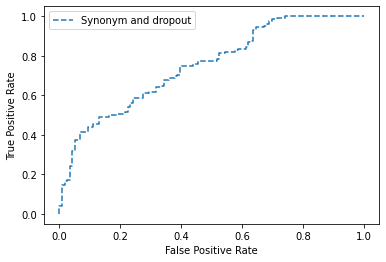

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.5985401459854015
precision_true: 0.6081504702194357
precision_fake: 0.5851528384279476
recall_true: 0.671280276816609
recall_fake: 0.5173745173745173
f1score_true: 0.638157894736842
f1score_fake: 0.5491803278688524
Binary_loss 0.837989
*******TEACHER*************
accuracy: 0.6697080291970803
precision_true: 0.86
precision_fake: 0.5979899497487438
recall_true: 0.4463667820069204
recall_fake: 0.918918918918919
f1score_true: 0.5876993166287016
f1score_fake: 0.7245053272450533
Binary_loss 0.6455219
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6624087591240876
precision_true: 0.6595092024539877
precision_fake: 0.6666666666666666
recall_true: 0.7439446366782007
recall_fake: 0.5714285714285714
f1score_true: 0.6991869918699186
f1score_fake: 0.6153846153846153
Binary_loss 1.1630574
*******TEACHER*************
accuracy: 0.6697080291970803
precision_true: 0.7934782608

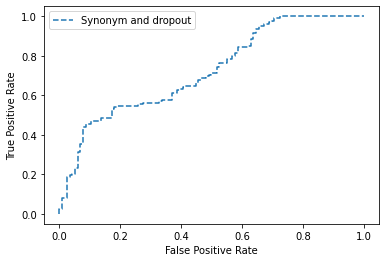

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6332116788321168
precision_true: 0.6128205128205129
precision_fake: 0.6835443037974683
recall_true: 0.8269896193771626
recall_fake: 0.416988416988417
f1score_true: 0.7039764359351989
f1score_fake: 0.5179856115107914
Binary_loss 1.0168417
*******TEACHER*************
accuracy: 0.6751824817518248
precision_true: 0.8135593220338984
precision_fake: 0.6091644204851752
recall_true: 0.4982698961937716
recall_fake: 0.8725868725868726
f1score_true: 0.6180257510729613
f1score_fake: 0.7174603174603175
Binary_loss 0.8148375
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6313868613138686
precision_true: 0.610126582278481
precision_fake: 0.6862745098039216
recall_true: 0.8339100346020761
recall_fake: 0.40540540540540543
f1score_true: 0.7046783625730995
f1score_fake: 0.5097087378640777
Binary_loss 0.872136
*******TEACHER*************
accuracy: 0.6496350364963503
precision_tr

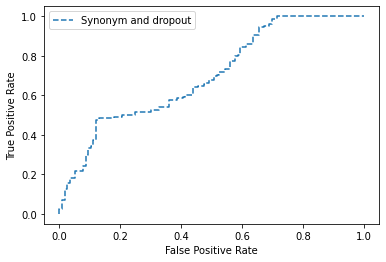

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6423357664233577
precision_true: 0.6207792207792208
precision_fake: 0.6932515337423313
recall_true: 0.8269896193771626
recall_fake: 0.4362934362934363
f1score_true: 0.7091988130563798
f1score_fake: 0.5355450236966824
Binary_loss 1.1220804
*******TEACHER*************
accuracy: 0.6021897810218978
precision_true: 0.6072507552870091
precision_fake: 0.5944700460829493
recall_true: 0.6955017301038062
recall_fake: 0.4980694980694981
f1score_true: 0.6483870967741935
f1score_fake: 0.542016806722689
Binary_loss 0.8781997
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.635036496350365
precision_true: 0.6312684365781711
precision_fake: 0.6411483253588517
recall_true: 0.740484429065744
recall_fake: 0.5173745173745173
f1score_true: 0.6815286624203821
f1score_fake: 0.5726495726495727
Binary_loss 0.96031123
*******TEACHER*************
accuracy: 0.6094890510948905
precision_tr

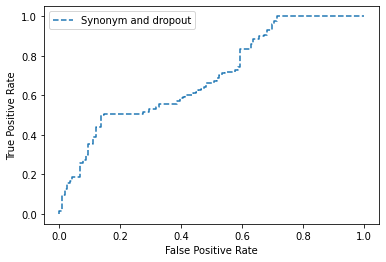

-----------------------------------------------------------------
train Data_Size: (2189, 100)
test Data_Size: (244, 100)
Train Label count: True, Fake 1129 1060
Test Label count : True, Fake 130 114
Train Mean teacher Model...
26/26 [==============================] - 12s 460ms/step - loss: 0.6932 - accuracy: 0.5149
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.5
precision_true: 0.0
precision_fake: 0.5
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6666666666666666
Binary_loss 0.69298697
*******TEACHER*************
accuracy: 0.5018248175182481
precision_true: 0.5014164305949008
precision_fake: 0.5025641025641026
recall_true: 0.6459854014598541
recall_fake: 0.35766423357664234
f1score_true: 0.5645933014354068
f1score_fake: 0.417910447761194
Binary_loss 0.6931361
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5
precision_true: 0.5
precision_fake: 0.5
recall_true: 0.6605839416058394
recall_fake: 0.33941605839416056
f1score_true: 0.5691823899371069
f1score_fake: 0.4043478260869565
Binary_loss 0.69258606
*******TEACHER*************
accuracy: 0.5
precision_true: 0.0
precision_fake: 0.5
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6666666666666666
Binary_loss 0.6930471
* * * * * * * * * * * * * * * * *
Start of e

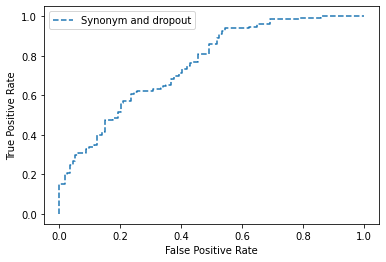

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.5529197080291971
precision_true: 0.8372093023255814
precision_fake: 0.5287128712871287
recall_true: 0.13138686131386862
recall_fake: 0.9744525547445255
f1score_true: 0.2271293375394322
f1score_fake: 0.6854942233632862
Binary_loss 0.7678616
*******TEACHER*************
accuracy: 0.6186131386861314
precision_true: 0.9710144927536232
precision_fake: 0.5678496868475992
recall_true: 0.24452554744525548
recall_fake: 0.9927007299270073
f1score_true: 0.39067055393586003
f1score_fake: 0.7224435590969456
Binary_loss 0.6683995
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5894160583941606
precision_true: 0.9016393442622951
precision_fake: 0.5503080082135524
recall_true: 0.20072992700729927
recall_fake: 0.9781021897810219
f1score_true: 0.3283582089552239
f1score_fake: 0.7043363994743759
Binary_loss 0.71913457
*******TEACHER*************
accuracy: 0.6021897810218978
preci

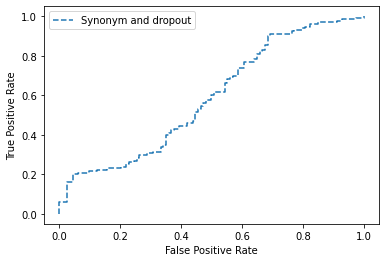

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6222627737226277
precision_true: 0.9036144578313253
precision_fake: 0.5720430107526882
recall_true: 0.2737226277372263
recall_fake: 0.9708029197080292
f1score_true: 0.4201680672268907
f1score_fake: 0.7198917456021651
Binary_loss 0.8598112
*******TEACHER*************
accuracy: 0.5948905109489051
precision_true: 0.9333333333333333
precision_fake: 0.5532786885245902
recall_true: 0.20437956204379562
recall_fake: 0.9854014598540146
f1score_true: 0.33532934131736525
f1score_fake: 0.7086614173228347
Binary_loss 0.68076026
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6204379562043796
precision_true: 0.8586956521739131
precision_fake: 0.5723684210526315
recall_true: 0.28832116788321166
recall_fake: 0.9525547445255474
f1score_true: 0.43169398907103823
f1score_fake: 0.7150684931506849
Binary_loss 0.7321498
*******TEACHER*************
accuracy: 0.6113138686131386
preci

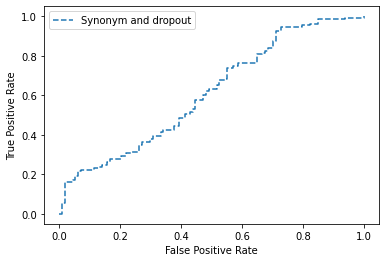

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6332116788321168
precision_true: 0.9195402298850575
precision_fake: 0.579175704989154
recall_true: 0.291970802919708
recall_fake: 0.9744525547445255
f1score_true: 0.44321329639889195
f1score_fake: 0.726530612244898
Binary_loss 0.7532563
*******TEACHER*************
accuracy: 0.6222627737226277
precision_true: 0.8941176470588236
precision_fake: 0.572354211663067
recall_true: 0.2773722627737226
recall_fake: 0.9671532846715328
f1score_true: 0.4233983286908078
f1score_fake: 0.7191316146540028
Binary_loss 0.6981125
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6186131386861314
precision_true: 0.773109243697479
precision_fake: 0.5757575757575758
recall_true: 0.3357664233576642
recall_fake: 0.9014598540145985
f1score_true: 0.46819338422391854
f1score_fake: 0.7027027027027027
Binary_loss 0.764134
*******TEACHER*************
accuracy: 0.6259124087591241
precision_true

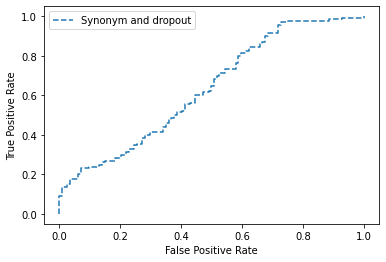

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6277372262773723
precision_true: 0.6966292134831461
precision_fake: 0.5945945945945946
recall_true: 0.45255474452554745
recall_fake: 0.8029197080291971
f1score_true: 0.5486725663716814
f1score_fake: 0.6832298136645963
Binary_loss 0.8522572
*******TEACHER*************
accuracy: 0.6277372262773723
precision_true: 0.8977272727272727
precision_fake: 0.5760869565217391
recall_true: 0.28832116788321166
recall_fake: 0.9671532846715328
f1score_true: 0.43646408839779
f1score_fake: 0.7220708446866485
Binary_loss 0.7499735
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6313868613138686
precision_true: 0.9
precision_fake: 0.5786026200873362
recall_true: 0.2956204379562044
recall_fake: 0.9671532846715328
f1score_true: 0.44505494505494503
f1score_fake: 0.7240437158469946
Binary_loss 0.8454174
*******TEACHER*************
accuracy: 0.6313868613138686
precision_true: 0.9
prec

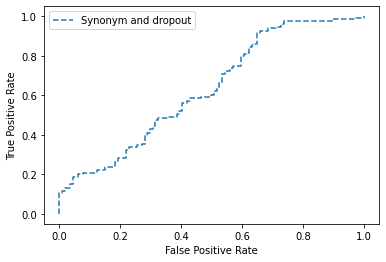

-----------------------------------------------------------------
train Data_Size: (2189, 100)
test Data_Size: (244, 100)
Train Label count: True, Fake 1131 1058
Test Label count : True, Fake 128 116
Train Mean teacher Model...
26/26 [==============================] - 11s 436ms/step - loss: 0.6923 - accuracy: 0.5302
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.48175182481751827
precision_true: 1.0
precision_fake: 0.47794117647058826
recall_true: 0.013888888888888888
recall_fake: 1.0
f1score_true: 0.0273972602739726
f1score_fake: 0.6467661691542288
Binary_loss 0.6923806
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.4744525547445255
precision_true: 0.0
precision_fake: 0.4744525547445255
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6435643564356436
Binary_loss 0.6928172
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.4835766423357664
precision_true: 1.0
precision_fake: 0.47882136279926335
recall_true: 0.017361111111111112
recall_fake: 1.0
f1score_true: 0.034129692832764506
f1score_fake: 0.647571606475716
Binary_loss 0.691594
*******TEACHER*************
accuracy: 0.4744525547445255
precision_true: 0.0
precision_fake: 0.4744525547445255
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6435643564356436
Binary_loss 0.69304496
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.48722627737226276
precision_true: 1.0
precision_fake: 0.4805914972273567
recall_true: 0.024305555555555556
recall_fak

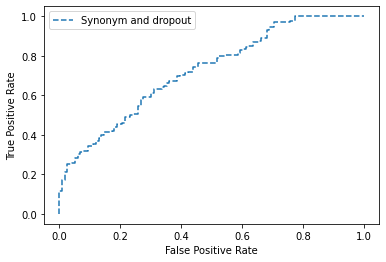

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6368613138686131
precision_true: 0.7192118226600985
precision_fake: 0.5884057971014492
recall_true: 0.5069444444444444
recall_fake: 0.7807692307692308
f1score_true: 0.594704684317719
f1score_fake: 0.6710743801652893
Binary_loss 1.3935478
*******TEACHER*************
accuracy: 0.6459854014598541
precision_true: 0.6151960784313726
precision_fake: 0.7357142857142858
recall_true: 0.8715277777777778
recall_fake: 0.39615384615384613
f1score_true: 0.721264367816092
f1score_fake: 0.515
Binary_loss 0.6700215
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6204379562043796
precision_true: 0.7061855670103093
precision_fake: 0.5734463276836158
recall_true: 0.4756944444444444
recall_fake: 0.7807692307692308
f1score_true: 0.5684647302904565
f1score_fake: 0.6612377850162866
Binary_loss 1.3153868
*******TEACHER*************
accuracy: 0.6642335766423357
precision_true: 0.628712

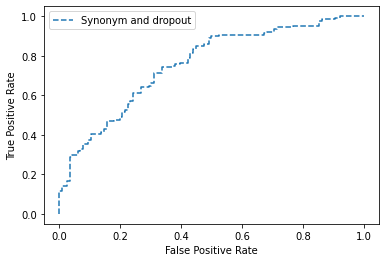

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6405109489051095
precision_true: 0.6936170212765957
precision_fake: 0.6006389776357828
recall_true: 0.5659722222222222
recall_fake: 0.7230769230769231
f1score_true: 0.6233269598470362
f1score_fake: 0.656195462478185
Binary_loss 1.549593
*******TEACHER*************
accuracy: 0.6551094890510949
precision_true: 0.6633663366336634
precision_fake: 0.6448979591836734
recall_true: 0.6979166666666666
recall_fake: 0.6076923076923076
f1score_true: 0.6802030456852792
f1score_fake: 0.6257425742574257
Binary_loss 1.1540687
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.583941605839416
precision_true: 0.7380952380952381
precision_fake: 0.5379146919431279
recall_true: 0.3229166666666667
recall_fake: 0.8730769230769231
f1score_true: 0.4492753623188406
f1score_fake: 0.6656891495601173
Binary_loss 2.0876765
*******TEACHER*************
accuracy: 0.6496350364963503
precision_tru

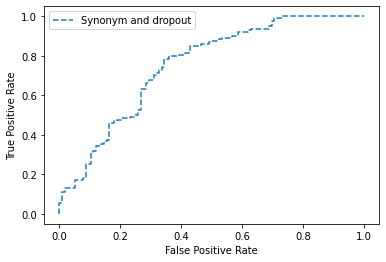

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6368613138686131
precision_true: 0.6403785488958991
precision_fake: 0.6320346320346321
recall_true: 0.7048611111111112
recall_fake: 0.5615384615384615
f1score_true: 0.6710743801652892
f1score_fake: 0.594704684317719
Binary_loss 1.4912018
*******TEACHER*************
accuracy: 0.6532846715328468
precision_true: 0.6503067484662577
precision_fake: 0.6576576576576577
recall_true: 0.7361111111111112
recall_fake: 0.5615384615384615
f1score_true: 0.6905537459283388
f1score_fake: 0.6058091286307054
Binary_loss 1.3503653
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6332116788321168
precision_true: 0.6629213483146067
precision_fake: 0.604982206405694
recall_true: 0.6145833333333334
recall_fake: 0.6538461538461539
f1score_true: 0.6378378378378379
f1score_fake: 0.6284658040665435
Binary_loss 1.5264934
*******TEACHER*************
accuracy: 0.6532846715328468
precision_tr

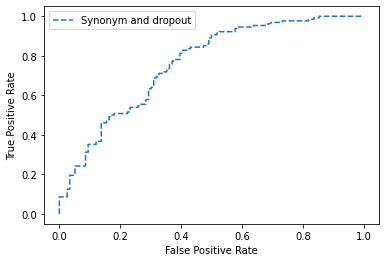

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6259124087591241
precision_true: 0.6751054852320675
precision_fake: 0.5884244372990354
recall_true: 0.5555555555555556
recall_fake: 0.7038461538461539
f1score_true: 0.6095238095238096
f1score_fake: 0.6409807355516638
Binary_loss 1.580755
*******TEACHER*************
accuracy: 0.6368613138686131
precision_true: 0.6679245283018868
precision_fake: 0.607773851590106
recall_true: 0.6145833333333334
recall_fake: 0.6615384615384615
f1score_true: 0.6401446654611213
f1score_fake: 0.6335174953959484
Binary_loss 1.4651073
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6368613138686131
precision_true: 0.6529209621993127
precision_fake: 0.6186770428015564
recall_true: 0.6597222222222222
recall_fake: 0.6115384615384616
f1score_true: 0.6563039723661486
f1score_fake: 0.6150870406189556
Binary_loss 1.3972425
*******TEACHER*************
accuracy: 0.635036496350365
precision_tru

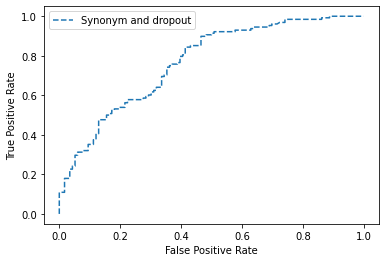

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1131 1059
Test Label count : True, Fake 128 115
Train Mean teacher Model...
26/26 [==============================] - 11s 430ms/step - loss: 0.6930 - accuracy: 0.5110
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.49635036496350365
precision_true: 0.64
precision_fake: 0.4819277108433735
recall_true: 0.1103448275862069
recall_fake: 0.9302325581395349
f1score_true: 0.18823529411764706
f1score_fake: 0.6349206349206349
Binary_loss 0.69161916
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.4708029197080292
precision_true: 0.0
precision_fake: 0.4708029197080292
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.640198511166253
Binary_loss 0.693271
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.551094890510949
precision_true: 0.7156862745098039
precision_fake: 0.5134529147982063
recall_true: 0.2517241379310345
recall_fake: 0.8875968992248062
f1score_true: 0.3724489795918367
f1score_fake: 0.6505681818181819
Binary_loss 0.6904783
*******TEACHER*************
accuracy: 0.4708029197080292
precision_true: 0.0
precision_fake: 0.4708029197080292
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.640198511166253
Binary_loss 0.69324386
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5054744525547445
precision_true: 0.9130434782608695
precision_fake: 0.4876190476190476
recall_

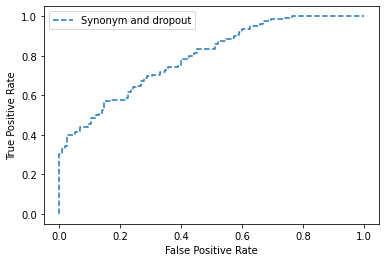

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6952554744525548
precision_true: 0.6666666666666666
precision_fake: 0.7541899441340782
recall_true: 0.8482758620689655
recall_fake: 0.5232558139534884
f1score_true: 0.7465857359635812
f1score_fake: 0.6178489702517164
Binary_loss 0.63133425
*******TEACHER*************
accuracy: 0.6697080291970803
precision_true: 0.6401028277634961
precision_fake: 0.7421383647798742
recall_true: 0.8586206896551725
recall_fake: 0.4573643410852713
f1score_true: 0.7334315169366716
f1score_fake: 0.5659472422062349
Binary_loss 0.6503859
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6916058394160584
precision_true: 0.6896551724137931
precision_fake: 0.6943231441048034
recall_true: 0.7586206896551724
recall_fake: 0.6162790697674418
f1score_true: 0.722495894909688
f1score_fake: 0.6529774127310062
Binary_loss 0.85773003
*******TEACHER*************
accuracy: 0.6824817518248175
precision

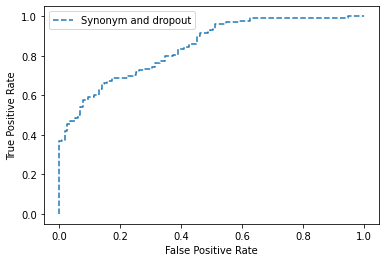

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6259124087591241
precision_true: 0.683982683982684
precision_fake: 0.583596214511041
recall_true: 0.5448275862068965
recall_fake: 0.7170542635658915
f1score_true: 0.6065259117082533
f1score_fake: 0.6434782608695652
Binary_loss 1.2090397
*******TEACHER*************
accuracy: 0.6934306569343066
precision_true: 0.6622340425531915
precision_fake: 0.7616279069767442
recall_true: 0.8586206896551725
recall_fake: 0.5077519379844961
f1score_true: 0.7477477477477478
f1score_fake: 0.6093023255813954
Binary_loss 0.5937098
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5802919708029197
precision_true: 0.6119402985074627
precision_fake: 0.55
recall_true: 0.5655172413793104
recall_fake: 0.5968992248062015
f1score_true: 0.5878136200716846
f1score_fake: 0.5724907063197027
Binary_loss 0.96930254
*******TEACHER*************
accuracy: 0.6733576642335767
precision_true: 0.6646884

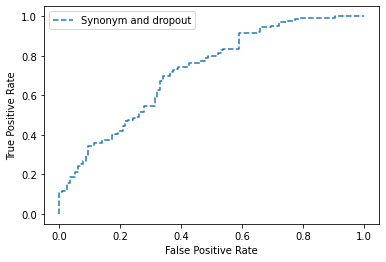

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6423357664233577
precision_true: 0.6477987421383647
precision_fake: 0.6347826086956522
recall_true: 0.7103448275862069
recall_fake: 0.5658914728682171
f1score_true: 0.6776315789473684
f1score_fake: 0.5983606557377049
Binary_loss 0.7115395
*******TEACHER*************
accuracy: 0.6405109489051095
precision_true: 0.6388059701492538
precision_fake: 0.6431924882629108
recall_true: 0.7379310344827587
recall_fake: 0.5310077519379846
f1score_true: 0.6848000000000001
f1score_fake: 0.5817409766454352
Binary_loss 0.62010884
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6459854014598541
precision_true: 0.6678321678321678
precision_fake: 0.6221374045801527
recall_true: 0.6586206896551724
recall_fake: 0.6317829457364341
f1score_true: 0.6631944444444444
f1score_fake: 0.6269230769230769
Binary_loss 0.8904994
*******TEACHER*************
accuracy: 0.6368613138686131
precision

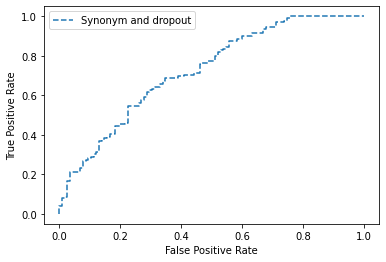

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6678832116788321
precision_true: 0.7030075187969925
precision_fake: 0.6347517730496454
recall_true: 0.6448275862068965
recall_fake: 0.6937984496124031
f1score_true: 0.6726618705035972
f1score_fake: 0.662962962962963
Binary_loss 0.92566466
*******TEACHER*************
accuracy: 0.6368613138686131
precision_true: 0.6704119850187266
precision_fake: 0.604982206405694
recall_true: 0.6172413793103448
recall_fake: 0.6589147286821705
f1score_true: 0.6427289048473968
f1score_fake: 0.6307977736549165
Binary_loss 0.7637236
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6678832116788321
precision_true: 0.7093023255813954
precision_fake: 0.6310344827586207
recall_true: 0.6310344827586207
recall_fake: 0.7093023255813954
f1score_true: 0.6678832116788322
f1score_fake: 0.6678832116788322
Binary_loss 1.0435656
*******TEACHER*************
accuracy: 0.6496350364963503
precision_t

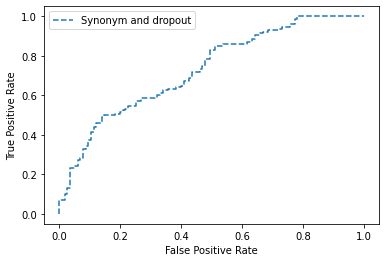

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1142 1048
Test Label count : True, Fake 117 126
Train Mean teacher Model...
26/26 [==============================] - 11s 438ms/step - loss: 0.6917 - accuracy: 0.5323
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.5
precision_true: 1.0
precision_fake: 0.4972477064220184
recall_true: 0.010830324909747292
recall_fake: 1.0
f1score_true: 0.02142857142857143
f1score_fake: 0.6642156862745098
Binary_loss 0.6925197
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.49452554744525545
precision_true: 0.0
precision_fake: 0.49452554744525545
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6617826617826618
Binary_loss 0.6926291
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5145985401459854
precision_true: 0.6410256410256411
precision_fake: 0.5049115913555993
recall_true: 0.09025270758122744
recall_fake: 0.948339483394834
f1score_true: 0.1582278481012658
f1score_fake: 0.658974358974359
Binary_loss 0.69118
*******TEACHER*************
accuracy: 0.49452554744525545
precision_true: 0.0
precision_fake: 0.49452554744525545
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6617826617826618
Binary_loss 0.6931272
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6003649635036497
precision_true: 0.5796703296703297
precision_fake: 0.6413043478260869
rec

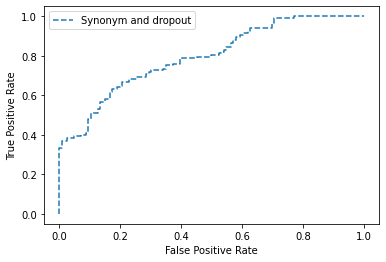

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6551094890510949
precision_true: 0.7588235294117647
precision_fake: 0.6084656084656085
recall_true: 0.4657039711191336
recall_fake: 0.8487084870848709
f1score_true: 0.5771812080536913
f1score_fake: 0.7087827426810479
Binary_loss 0.9724011
*******TEACHER*************
accuracy: 0.6624087591240876
precision_true: 0.6059907834101382
precision_fake: 0.8771929824561403
recall_true: 0.9494584837545126
recall_fake: 0.36900369003690037
f1score_true: 0.7398030942334741
f1score_fake: 0.5194805194805194
Binary_loss 0.65323
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6332116788321168
precision_true: 0.6484375
precision_fake: 0.6198630136986302
recall_true: 0.5992779783393501
recall_fake: 0.6678966789667896
f1score_true: 0.622889305816135
f1score_fake: 0.6429840142095915
Binary_loss 0.933057
*******TEACHER*************
accuracy: 0.6113138686131386
precision_true: 0.5879

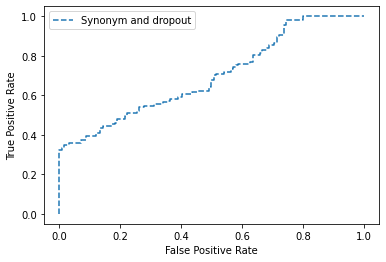

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6058394160583942
precision_true: 0.645933014354067
precision_fake: 0.5811209439528023
recall_true: 0.48736462093862815
recall_fake: 0.7269372693726938
f1score_true: 0.5555555555555556
f1score_fake: 0.6459016393442623
Binary_loss 0.77039254
*******TEACHER*************
accuracy: 0.6058394160583942
precision_true: 0.6055363321799307
precision_fake: 0.6061776061776062
recall_true: 0.631768953068592
recall_fake: 0.5793357933579336
f1score_true: 0.6183745583038869
f1score_fake: 0.5924528301886792
Binary_loss 0.5757396
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6113138686131386
precision_true: 0.6176470588235294
precision_fake: 0.605072463768116
recall_true: 0.6064981949458483
recall_fake: 0.6162361623616236
f1score_true: 0.6120218579234973
f1score_fake: 0.6106032906764168
Binary_loss 0.9356902
*******TEACHER*************
accuracy: 0.6167883211678832
precision_t

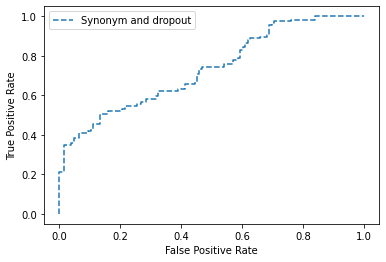

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6003649635036497
precision_true: 0.638095238095238
precision_fake: 0.5769230769230769
recall_true: 0.48375451263537905
recall_fake: 0.7195571955719557
f1score_true: 0.5503080082135523
f1score_fake: 0.6403940886699507
Binary_loss 1.1893193
*******TEACHER*************
accuracy: 0.6167883211678832
precision_true: 0.6200716845878136
precision_fake: 0.6133828996282528
recall_true: 0.6245487364620939
recall_fake: 0.6088560885608856
f1score_true: 0.6223021582733813
f1score_fake: 0.611111111111111
Binary_loss 0.8117273
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6259124087591241
precision_true: 0.6192052980132451
precision_fake: 0.6341463414634146
recall_true: 0.6750902527075813
recall_fake: 0.5756457564575646
f1score_true: 0.6459412780656305
f1score_fake: 0.6034816247582205
Binary_loss 1.1353097
*******TEACHER*************
accuracy: 0.6131386861313869
precision_t

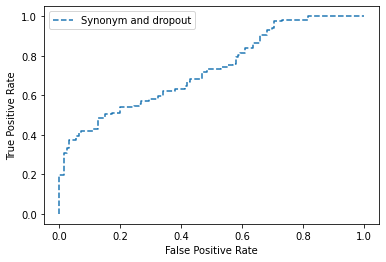

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.656934306569343
precision_true: 0.678714859437751
precision_fake: 0.6387959866220736
recall_true: 0.6101083032490975
recall_fake: 0.7047970479704797
f1score_true: 0.6425855513307985
f1score_fake: 0.6701754385964913
Binary_loss 1.5073677
*******TEACHER*************
accuracy: 0.6094890510948905
precision_true: 0.6162361623616236
precision_fake: 0.6028880866425993
recall_true: 0.6028880866425993
recall_fake: 0.6162361623616236
f1score_true: 0.6094890510948906
f1score_fake: 0.6094890510948906
Binary_loss 0.96202046
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6113138686131386
precision_true: 0.6290322580645161
precision_fake: 0.5966666666666667
recall_true: 0.5631768953068592
recall_fake: 0.6605166051660517
f1score_true: 0.5942857142857143
f1score_fake: 0.626970227670753
Binary_loss 1.1051601
*******TEACHER*************
accuracy: 0.6076642335766423
precision_tr

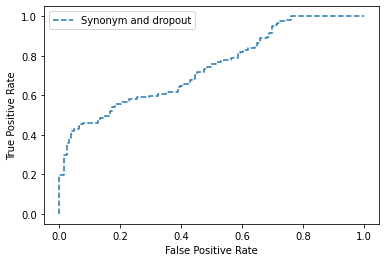

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1142 1048
Test Label count : True, Fake 117 126
Train Mean teacher Model...
26/26 [==============================] - 11s 439ms/step - loss: 0.6927 - accuracy: 0.5146
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.49452554744525545
precision_true: 0.6103896103896104
precision_fake: 0.47558386411889597
recall_true: 0.1598639455782313
recall_fake: 0.8818897637795275
f1score_true: 0.2533692722371968
f1score_fake: 0.6179310344827585
Binary_loss 0.69069386
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.4635036496350365
precision_true: 0.0
precision_fake: 0.4635036496350365
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6334164588528678
Binary_loss 0.6928091
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.541970802919708
precision_true: 0.6069651741293532
precision_fake: 0.5043227665706052
recall_true: 0.41496598639455784
recall_fake: 0.6889763779527559
f1score_true: 0.49292929292929305
f1score_fake: 0.5823627287853578
Binary_loss 0.689335
*******TEACHER*************
accuracy: 0.4635036496350365
precision_true: 0.0
precision_fake: 0.4635036496350365
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6334164588528678
Binary_loss 0.69316685
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6021897810218978
precision_true: 0.6194968553459119
precision_fake: 0.5782608695652174
rec

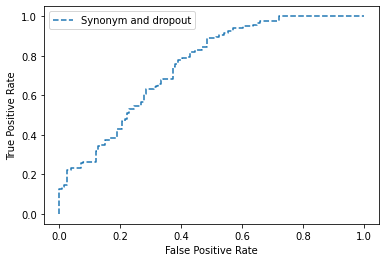

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6751824817518248
precision_true: 0.8222222222222222
precision_fake: 0.6032608695652174
recall_true: 0.5034013605442177
recall_fake: 0.8740157480314961
f1score_true: 0.6244725738396625
f1score_fake: 0.7138263665594855
Binary_loss 0.66500896
*******TEACHER*************
accuracy: 0.6605839416058394
precision_true: 0.7571428571428571
precision_fake: 0.6005917159763313
recall_true: 0.5408163265306123
recall_fake: 0.7992125984251969
f1score_true: 0.6309523809523809
f1score_fake: 0.6858108108108109
Binary_loss 0.65461755
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6733576642335767
precision_true: 0.8248587570621468
precision_fake: 0.601078167115903
recall_true: 0.4965986394557823
recall_fake: 0.8779527559055118
f1score_true: 0.6199575371549894
f1score_fake: 0.7136
Binary_loss 1.0161858
*******TEACHER*************
accuracy: 0.6496350364963503
precision_true: 0.777

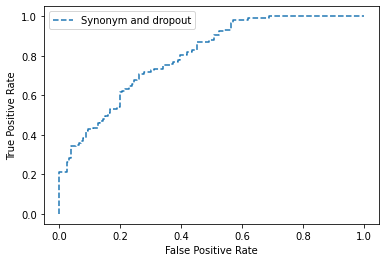

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6478102189781022
precision_true: 0.7044534412955465
precision_fake: 0.6013289036544851
recall_true: 0.5918367346938775
recall_fake: 0.7125984251968503
f1score_true: 0.643253234750462
f1score_fake: 0.6522522522522521
Binary_loss 1.3058225
*******TEACHER*************
accuracy: 0.6277372262773723
precision_true: 0.6541095890410958
precision_fake: 0.59765625
recall_true: 0.6496598639455783
recall_fake: 0.6023622047244095
f1score_true: 0.651877133105802
f1score_fake: 0.6
Binary_loss 0.5517984
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6605839416058394
precision_true: 0.7755102040816326
precision_fake: 0.5965909090909091
recall_true: 0.5170068027210885
recall_fake: 0.8267716535433071
f1score_true: 0.620408163265306
f1score_fake: 0.6930693069306931
Binary_loss 1.9443034
*******TEACHER*************
accuracy: 0.6204379562043796
precision_true: 0.6452702702702703
p

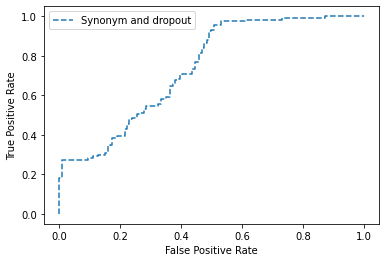

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6478102189781022
precision_true: 0.6246913580246913
precision_fake: 0.7132867132867133
recall_true: 0.8605442176870748
recall_fake: 0.4015748031496063
f1score_true: 0.7238912732474965
f1score_fake: 0.5138539042821159
Binary_loss 0.6485534
*******TEACHER*************
accuracy: 0.6222627737226277
precision_true: 0.6653992395437263
precision_fake: 0.5824561403508772
recall_true: 0.5952380952380952
recall_fake: 0.6535433070866141
f1score_true: 0.6283662477558349
f1score_fake: 0.6159554730983302
Binary_loss 0.77146393
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6733576642335767
precision_true: 0.6910299003322259
precision_fake: 0.6518218623481782
recall_true: 0.7074829931972789
recall_fake: 0.6338582677165354
f1score_true: 0.6991596638655462
f1score_fake: 0.6427145708582834
Binary_loss 1.1118851
*******TEACHER*************
accuracy: 0.6295620437956204
precision

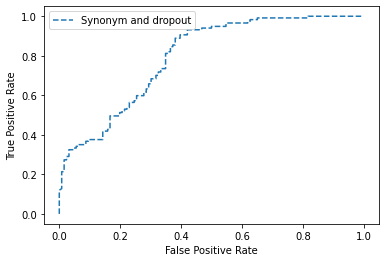

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6240875912408759
precision_true: 0.691304347826087
precision_fake: 0.5754716981132075
recall_true: 0.5408163265306123
recall_fake: 0.7204724409448819
f1score_true: 0.6068702290076337
f1score_fake: 0.6398601398601398
Binary_loss 1.11039
*******TEACHER*************
accuracy: 0.6240875912408759
precision_true: 0.6896551724137931
precision_fake: 0.5759493670886076
recall_true: 0.54421768707483
recall_fake: 0.7165354330708661
f1score_true: 0.6083650190114068
f1score_fake: 0.63859649122807
Binary_loss 1.0615804
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.635036496350365
precision_true: 0.75
precision_fake: 0.575
recall_true: 0.47959183673469385
recall_fake: 0.8149606299212598
f1score_true: 0.5850622406639004
f1score_fake: 0.6742671009771986
Binary_loss 2.0611548
*******TEACHER*************
accuracy: 0.6295620437956204
precision_true: 0.7022222222222222
precision

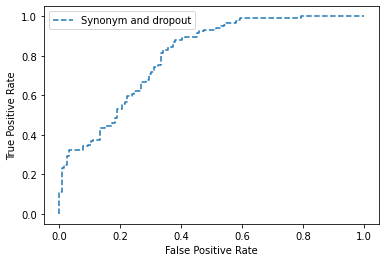

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1144 1046
Test Label count : True, Fake 115 128
Train Mean teacher Model...
26/26 [==============================] - 12s 444ms/step - loss: 0.6929 - accuracy: 0.5463
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.5273722627737226
precision_true: 0.532133676092545
precision_fake: 0.5157232704402516
recall_true: 0.7288732394366197
recall_fake: 0.3106060606060606
f1score_true: 0.6151560178306092
f1score_fake: 0.3877068557919621
Binary_loss 0.6919499
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.48175182481751827
precision_true: 0.0
precision_fake: 0.48175182481751827
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6502463054187192
Binary_loss 0.6927477
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5364963503649635
precision_true: 0.5375
precision_fake: 0.5337837837837838
recall_true: 0.7570422535211268
recall_fake: 0.29924242424242425
f1score_true: 0.628654970760234
f1score_fake: 0.38349514563106796
Binary_loss 0.69111586
*******TEACHER*************
accuracy: 0.48175182481751827
precision_true: 0.0
precision_fake: 0.48175182481751827
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6502463054187192
Binary_loss 0.692871
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5693430656934306
precision_true: 0.5574162679425837
precision_fake: 0.6076923076923076
recall_true

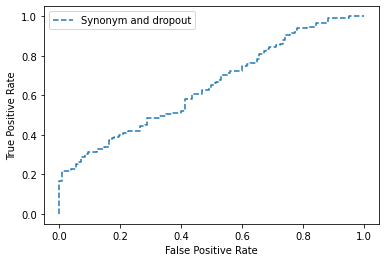

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6259124087591241
precision_true: 0.5817805383022774
precision_fake: 0.9538461538461539
recall_true: 0.9894366197183099
recall_fake: 0.23484848484848486
f1score_true: 0.7327249022164276
f1score_fake: 0.37689969604863216
Binary_loss 0.84625316
*******TEACHER*************
accuracy: 0.6021897810218978
precision_true: 0.9583333333333334
precision_fake: 0.5483193277310925
recall_true: 0.24295774647887325
recall_fake: 0.9886363636363636
f1score_true: 0.3876404494382023
f1score_fake: 0.7054054054054055
Binary_loss 0.67246366
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6313868613138686
precision_true: 0.5854166666666667
precision_fake: 0.9558823529411765
recall_true: 0.9894366197183099
recall_fake: 0.24621212121212122
f1score_true: 0.7356020942408377
f1score_fake: 0.39156626506024095
Binary_loss 0.9337756
*******TEACHER*************
accuracy: 0.6113138686131386
pre

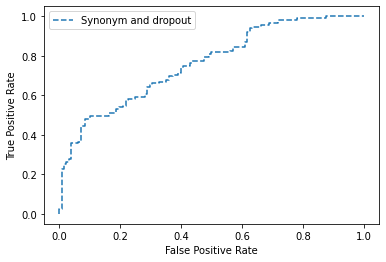

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6423357664233577
precision_true: 0.5936170212765958
precision_fake: 0.9358974358974359
recall_true: 0.9823943661971831
recall_fake: 0.2765151515151515
f1score_true: 0.7400530503978779
f1score_fake: 0.42690058479532156
Binary_loss 0.86400396
*******TEACHER*************
accuracy: 0.6441605839416058
precision_true: 0.5952890792291221
precision_fake: 0.9259259259259259
recall_true: 0.9788732394366197
recall_fake: 0.2840909090909091
f1score_true: 0.7403462050599202
f1score_fake: 0.4347826086956523
Binary_loss 0.6541565
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6423357664233577
precision_true: 0.5928270042194093
precision_fake: 0.9594594594594594
recall_true: 0.9894366197183099
recall_fake: 0.2689393939393939
f1score_true: 0.7414248021108181
f1score_fake: 0.42011834319526625
Binary_loss 1.0984132
*******TEACHER*************
accuracy: 0.6441605839416058
precisi

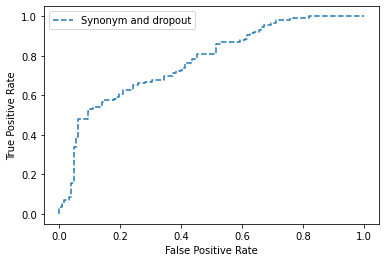

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6405109489051095
precision_true: 0.5931477516059958
precision_fake: 0.9135802469135802
recall_true: 0.9753521126760564
recall_fake: 0.2803030303030303
f1score_true: 0.7376830892143809
f1score_fake: 0.4289855072463767
Binary_loss 1.7942485
*******TEACHER*************
accuracy: 0.6496350364963503
precision_true: 0.5987124463519313
precision_fake: 0.9390243902439024
recall_true: 0.9823943661971831
recall_fake: 0.2916666666666667
f1score_true: 0.7440000000000001
f1score_fake: 0.4450867052023121
Binary_loss 1.1892893
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6441605839416058
precision_true: 0.5956989247311828
precision_fake: 0.9156626506024096
recall_true: 0.9753521126760564
recall_fake: 0.2878787878787879
f1score_true: 0.739652870493992
f1score_fake: 0.43804034582132567
Binary_loss 1.7362332
*******TEACHER*************
accuracy: 0.6459854014598541
precision_

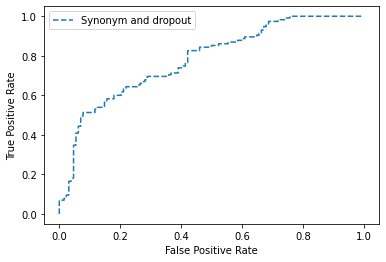

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6386861313868614
precision_true: 0.5914893617021276
precision_fake: 0.9230769230769231
recall_true: 0.9788732394366197
recall_fake: 0.2727272727272727
f1score_true: 0.7374005305039787
f1score_fake: 0.4210526315789473
Binary_loss 1.5417987
*******TEACHER*************
accuracy: 0.6405109489051095
precision_true: 0.5931477516059958
precision_fake: 0.9135802469135802
recall_true: 0.9753521126760564
recall_fake: 0.2803030303030303
f1score_true: 0.7376830892143809
f1score_fake: 0.4289855072463767
Binary_loss 1.4032962
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.635036496350365
precision_true: 0.5897435897435898
precision_fake: 0.9
recall_true: 0.971830985915493
recall_fake: 0.2727272727272727
f1score_true: 0.7340425531914894
f1score_fake: 0.41860465116279066
Binary_loss 1.6490386
*******TEACHER*************
accuracy: 0.6405109489051095
precision_true: 0.59314775

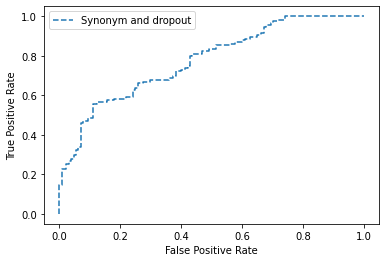

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1126 1064
Test Label count : True, Fake 133 110
Train Mean teacher Model...
26/26 [==============================] - 11s 431ms/step - loss: 0.6930 - accuracy: 0.5213
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.5018248175182481
precision_true: 0.6016260162601627
precision_fake: 0.47294117647058825
recall_true: 0.2483221476510067
recall_fake: 0.804
f1score_true: 0.3515439429928741
f1score_fake: 0.5955555555555556
Binary_loss 0.6913261
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.4562043795620438
precision_true: 0.0
precision_fake: 0.4562043795620438
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6265664160401002
Binary_loss 0.69244814
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.4744525547445255
precision_true: 0.7272727272727273
precision_fake: 0.46387832699619774
recall_true: 0.053691275167785234
recall_fake: 0.976
f1score_true: 0.09999999999999999
f1score_fake: 0.6288659793814434
Binary_loss 0.690818
*******TEACHER*************
accuracy: 0.4562043795620438
precision_true: 0.0
precision_fake: 0.4562043795620438
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6265664160401002
Binary_loss 0.6927799
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5109489051094891
precision_true: 0.6190476190476191
precision_fake: 0.4786729857819905
recall_true: 

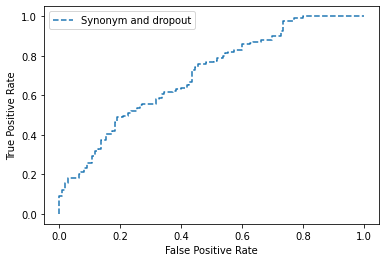

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6332116788321168
precision_true: 0.7904191616766467
precision_fake: 0.5643044619422573
recall_true: 0.4429530201342282
recall_fake: 0.86
f1score_true: 0.567741935483871
f1score_fake: 0.6814580031695722
Binary_loss 0.7775555
*******TEACHER*************
accuracy: 0.6678832116788321
precision_true: 0.6294642857142857
precision_fake: 0.84
recall_true: 0.9463087248322147
recall_fake: 0.336
f1score_true: 0.7560321715817694
f1score_fake: 0.48000000000000004
Binary_loss 0.6594961
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7116788321167883
precision_true: 0.7734375
precision_fake: 0.6575342465753424
recall_true: 0.6644295302013423
recall_fake: 0.768
f1score_true: 0.7148014440433214
f1score_fake: 0.7084870848708487
Binary_loss 0.8186834
*******TEACHER*************
accuracy: 0.6843065693430657
precision_true: 0.6443418013856813
precision_fake: 0.8347826086956521
rec

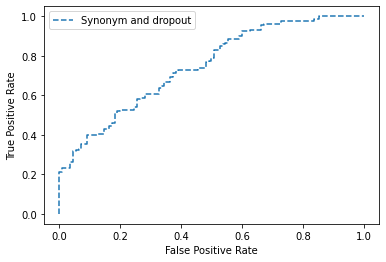

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6824817518248175
precision_true: 0.7719298245614035
precision_fake: 0.61875
recall_true: 0.5906040268456376
recall_fake: 0.792
f1score_true: 0.6692015209125475
f1score_fake: 0.6947368421052631
Binary_loss 0.98841834
*******TEACHER*************
accuracy: 0.7062043795620438
precision_true: 0.7188498402555911
precision_fake: 0.6893617021276596
recall_true: 0.7550335570469798
recall_fake: 0.648
f1score_true: 0.7364975450081833
f1score_fake: 0.668041237113402
Binary_loss 0.56886375
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6624087591240876
precision_true: 0.775609756097561
precision_fake: 0.5947521865889213
recall_true: 0.5335570469798657
recall_fake: 0.816
f1score_true: 0.63220675944334
f1score_fake: 0.6880269814502529
Binary_loss 1.0064175
*******TEACHER*************
accuracy: 0.6605839416058394
precision_true: 0.71875
precision_fake: 0.6095890410958904
rec

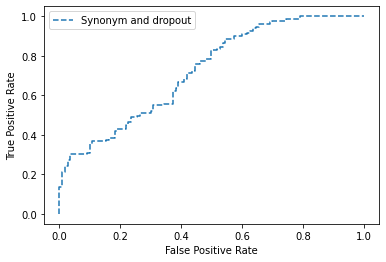

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.5967153284671532
precision_true: 0.6994818652849741
precision_fake: 0.5408450704225352
recall_true: 0.45302013422818793
recall_fake: 0.768
f1score_true: 0.54989816700611
f1score_fake: 0.6347107438016528
Binary_loss 1.195036
*******TEACHER*************
accuracy: 0.6368613138686131
precision_true: 0.7619047619047619
precision_fake: 0.5710306406685237
recall_true: 0.48322147651006714
recall_fake: 0.82
f1score_true: 0.5913757700205339
f1score_fake: 0.6732348111658456
Binary_loss 0.8591154
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6113138686131386
precision_true: 0.6824034334763949
precision_fake: 0.5587301587301587
recall_true: 0.5335570469798657
recall_fake: 0.704
f1score_true: 0.5988700564971752
f1score_fake: 0.6230088495575221
Binary_loss 0.73450327
*******TEACHER*************
accuracy: 0.6423357664233577
precision_true: 0.7833333333333333
precision_fake:

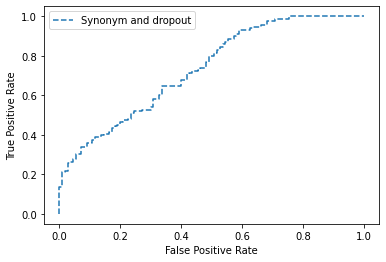

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6587591240875912
precision_true: 0.6819672131147541
precision_fake: 0.6296296296296297
recall_true: 0.697986577181208
recall_fake: 0.612
f1score_true: 0.6898839137645109
f1score_fake: 0.6206896551724138
Binary_loss 1.1477193
*******TEACHER*************
accuracy: 0.6386861313868614
precision_true: 0.7314814814814815
precision_fake: 0.5783132530120482
recall_true: 0.5302013422818792
recall_fake: 0.768
f1score_true: 0.6147859922178989
f1score_fake: 0.6597938144329897
Binary_loss 1.0087827
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.572992700729927
precision_true: 0.6212121212121212
precision_fake: 0.528169014084507
recall_true: 0.5503355704697986
recall_fake: 0.6
f1score_true: 0.5836298932384342
f1score_fake: 0.5617977528089887
Binary_loss 0.9765129
*******TEACHER*************
accuracy: 0.6295620437956204
precision_true: 0.7188940092165899
precision_fake: 0.5

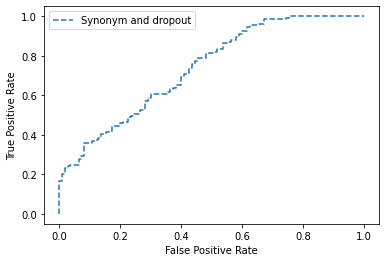

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1128 1062
Test Label count : True, Fake 131 112
Train Mean teacher Model...
26/26 [==============================] - 11s 434ms/step - loss: 0.6925 - accuracy: 0.5207
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.5218978102189781
precision_true: 0.5490196078431373
precision_fake: 0.49829351535836175
recall_true: 0.4878048780487805
recall_fake: 0.5593869731800766
f1score_true: 0.5166051660516605
f1score_fake: 0.5270758122743682
Binary_loss 0.6912178
*******TEACHER*************
accuracy: 0.48905109489051096
precision_true: 0.5421686746987951
precision_fake: 0.47956989247311826
recall_true: 0.156794425087108
recall_fake: 0.8544061302681992
f1score_true: 0.24324324324324323
f1score_fake: 0.6143250688705233
Binary_loss 0.69186103
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.4854014598540146
precision_true: 0.7777777777777778
precision_fake: 0.4805194805194805
recall_true: 0.024390243902439025
recall_fake: 0.9923371647509579
f1score_true: 0.0472972972972973
f1score_fake: 0.6475
Binary_loss 0.6906838
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.4762773722627737
precision_true: 0.0
precision_fake: 0.4762773722627737
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6452410383189122
Binary_loss 0.6923797
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5200729927007299
precision_true: 0.581081081081081
precision_fake: 0.4975
recall_true: 0.29965156794425085
recall_fake: 0.7624521072796935
f1score_true: 0.3954022988505747
f1score_fake: 0.6021180030257186
Binary_loss 0.68884975
*******TEACHER*************
accuracy: 0.4762773722627737
precision_true: 0.0
precision_fake: 0.4762773722627737
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6452410383189122
Binary_loss 0.69238704
* * * * * * * * * * * * * * * * *
Start of epoch 4
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5145985401459854
precision_true: 0.5376344086021505
precision_fake: 0.49070631970260226
recall_true: 

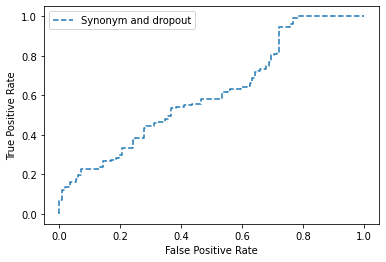

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6259124087591241
precision_true: 0.7070707070707071
precision_fake: 0.58
recall_true: 0.4878048780487805
recall_fake: 0.7777777777777778
f1score_true: 0.5773195876288659
f1score_fake: 0.6644844517184942
Binary_loss 0.83482385
*******TEACHER*************
accuracy: 0.6295620437956204
precision_true: 0.5967741935483871
precision_fake: 0.7543859649122807
recall_true: 0.9024390243902439
recall_fake: 0.32950191570881227
f1score_true: 0.7184466019417476
f1score_fake: 0.45866666666666667
Binary_loss 0.65580285
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6003649635036497
precision_true: 0.7428571428571429
precision_fake: 0.5514705882352942
recall_true: 0.3623693379790941
recall_fake: 0.8620689655172413
f1score_true: 0.48711943793911006
f1score_fake: 0.6726457399103138
Binary_loss 0.81040096
*******TEACHER*************
accuracy: 0.6532846715328468
precision_true: 0.

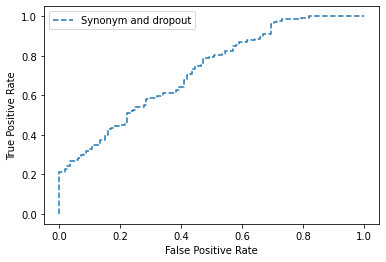

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6277372262773723
precision_true: 0.7902097902097902
precision_fake: 0.5703703703703704
recall_true: 0.39372822299651566
recall_fake: 0.8850574712643678
f1score_true: 0.5255813953488373
f1score_fake: 0.6936936936936938
Binary_loss 1.3523027
*******TEACHER*************
accuracy: 0.6879562043795621
precision_true: 0.6676300578034682
precision_fake: 0.7227722772277227
recall_true: 0.8048780487804879
recall_fake: 0.5593869731800766
f1score_true: 0.7298578199052133
f1score_fake: 0.630669546436285
Binary_loss 0.5508905
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6624087591240876
precision_true: 0.7256637168141593
precision_fake: 0.6180124223602484
recall_true: 0.5714285714285714
recall_fake: 0.7624521072796935
f1score_true: 0.6393762183235867
f1score_fake: 0.6826758147512864
Binary_loss 0.9531427
*******TEACHER*************
accuracy: 0.6861313868613139
precision_

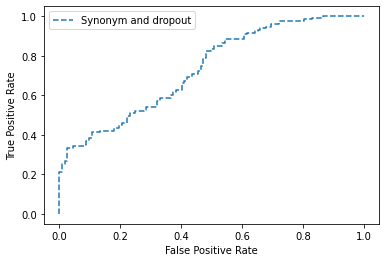

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6496350364963503
precision_true: 0.7386934673366834
precision_fake: 0.5988538681948424
recall_true: 0.5121951219512195
recall_fake: 0.8007662835249042
f1score_true: 0.6049382716049382
f1score_fake: 0.6852459016393443
Binary_loss 1.1537129
*******TEACHER*************
accuracy: 0.656934306569343
precision_true: 0.726027397260274
precision_fake: 0.6109422492401215
recall_true: 0.554006968641115
recall_fake: 0.7701149425287356
f1score_true: 0.6284584980237155
f1score_fake: 0.6813559322033899
Binary_loss 0.7950893
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6040145985401459
precision_true: 0.6620370370370371
precision_fake: 0.5662650602409639
recall_true: 0.49825783972125437
recall_fake: 0.7203065134099617
f1score_true: 0.5685884691848907
f1score_fake: 0.6340640809443508
Binary_loss 0.9868713
*******TEACHER*************
accuracy: 0.6587591240875912
precision_tr

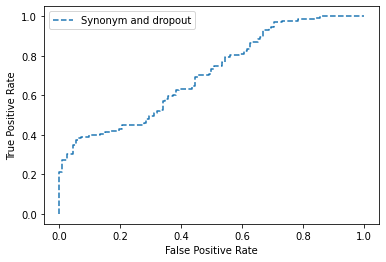

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6514598540145985
precision_true: 0.6538461538461539
precision_fake: 0.6483050847457628
recall_true: 0.710801393728223
recall_fake: 0.5862068965517241
f1score_true: 0.6811352253756261
f1score_fake: 0.6156941649899397
Binary_loss 1.063782
*******TEACHER*************
accuracy: 0.6514598540145985
precision_true: 0.7
precision_fake: 0.6136363636363636
recall_true: 0.5853658536585366
recall_fake: 0.7241379310344828
f1score_true: 0.6375711574952562
f1score_fake: 0.664323374340949
Binary_loss 0.97550327
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6624087591240876
precision_true: 0.7090163934426229
precision_fake: 0.625
recall_true: 0.6027874564459931
recall_fake: 0.7279693486590039
f1score_true: 0.6516007532956686
f1score_fake: 0.672566371681416
Binary_loss 1.3221673
*******TEACHER*************
accuracy: 0.6459854014598541
precision_true: 0.6768060836501901
precis

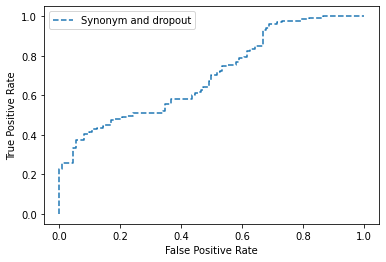

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1127 1063
Test Label count : True, Fake 132 111
Train Mean teacher Model...
26/26 [==============================] - 12s 447ms/step - loss: 0.6928 - accuracy: 0.5371
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.4908759124087591
precision_true: 1.0
precision_fake: 0.489945155393053
recall_true: 0.0035714285714285713
recall_fake: 1.0
f1score_true: 0.0071174377224199285
f1score_fake: 0.6576687116564417
Binary_loss 0.6924251
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.48905109489051096
precision_true: 0.0
precision_fake: 0.48905109489051096
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6568627450980392
Binary_loss 0.6929043
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5018248175182481
precision_true: 1.0
precision_fake: 0.4953789279112754
recall_true: 0.025
recall_fake: 1.0
f1score_true: 0.04878048780487806
f1score_fake: 0.6625463535228677
Binary_loss 0.6914449
*******TEACHER*************
accuracy: 0.48905109489051096
precision_true: 0.0
precision_fake: 0.48905109489051096
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6568627450980392
Binary_loss 0.69299084
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5383211678832117
precision_true: 1.0
precision_fake: 0.5143953934740882
recall_true: 0.09642857142857143
recall_fake: 1.0
f1scor

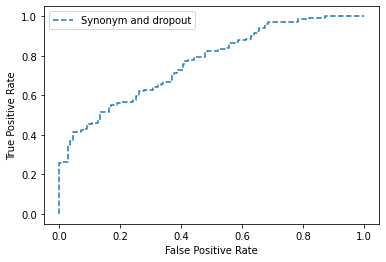

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6587591240875912
precision_true: 0.6867469879518072
precision_fake: 0.6354515050167224
recall_true: 0.6107142857142858
recall_fake: 0.7089552238805971
f1score_true: 0.6465028355387523
f1score_fake: 0.6701940035273368
Binary_loss 0.72680753
*******TEACHER*************
accuracy: 0.6496350364963503
precision_true: 0.5986547085201793
precision_fake: 0.8725490196078431
recall_true: 0.9535714285714286
recall_fake: 0.332089552238806
f1score_true: 0.7355371900826446
f1score_fake: 0.4810810810810811
Binary_loss 0.658666
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6459854014598541
precision_true: 0.715
precision_fake: 0.6063218390804598
recall_true: 0.5107142857142857
recall_fake: 0.7873134328358209
f1score_true: 0.5958333333333333
f1score_fake: 0.685064935064935
Binary_loss 0.77139294
*******TEACHER*************
accuracy: 0.666058394160584
precision_true: 0.6094808

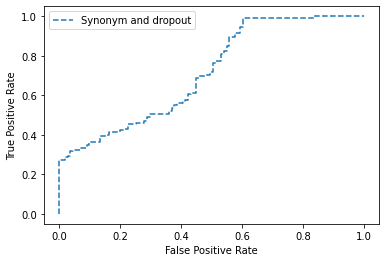

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6697080291970803
precision_true: 0.6896551724137931
precision_fake: 0.6515679442508711
recall_true: 0.6428571428571429
recall_fake: 0.6977611940298507
f1score_true: 0.6654343807763402
f1score_fake: 0.6738738738738738
Binary_loss 1.2262743
*******TEACHER*************
accuracy: 0.6313868613138686
precision_true: 0.6083333333333333
precision_fake: 0.675531914893617
recall_true: 0.7821428571428571
recall_fake: 0.47388059701492535
f1score_true: 0.684375
f1score_fake: 0.5570175438596491
Binary_loss 0.56880146
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6605839416058394
precision_true: 0.6546052631578947
precision_fake: 0.6680327868852459
recall_true: 0.7107142857142857
recall_fake: 0.6082089552238806
f1score_true: 0.6815068493150684
f1score_fake: 0.63671875
Binary_loss 0.9252385
*******TEACHER*************
accuracy: 0.6514598540145985
precision_true: 0.632047477

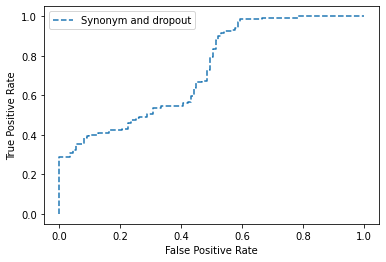

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6587591240875912
precision_true: 0.7486631016042781
precision_fake: 0.6121883656509696
recall_true: 0.5
recall_fake: 0.8246268656716418
f1score_true: 0.5995717344753748
f1score_fake: 0.7027027027027026
Binary_loss 1.5284054
*******TEACHER*************
accuracy: 0.6551094890510949
precision_true: 0.6704119850187266
precision_fake: 0.6405693950177936
recall_true: 0.6392857142857142
recall_fake: 0.6716417910447762
f1score_true: 0.6544789762340035
f1score_fake: 0.6557377049180328
Binary_loss 0.89204496
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6459854014598541
precision_true: 0.7388888888888889
precision_fake: 0.6005434782608695
recall_true: 0.475
recall_fake: 0.8246268656716418
f1score_true: 0.5782608695652174
f1score_fake: 0.6949685534591193
Binary_loss 1.8279744
*******TEACHER*************
accuracy: 0.6478102189781022
precision_true: 0.6835443037974683
pr

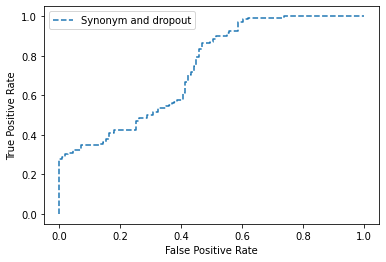

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.7153284671532847
precision_true: 0.697452229299363
precision_fake: 0.7393162393162394
recall_true: 0.7821428571428571
recall_fake: 0.6455223880597015
f1score_true: 0.7373737373737372
f1score_fake: 0.6892430278884463
Binary_loss 1.4629093
*******TEACHER*************
accuracy: 0.666058394160584
precision_true: 0.7012448132780082
precision_fake: 0.6384364820846905
recall_true: 0.6035714285714285
recall_fake: 0.7313432835820896
f1score_true: 0.6487523992322457
f1score_fake: 0.6817391304347826
Binary_loss 1.1657262
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6952554744525548
precision_true: 0.7250996015936255
precision_fake: 0.67003367003367
recall_true: 0.65
recall_fake: 0.7425373134328358
f1score_true: 0.6854990583804143
f1score_fake: 0.7044247787610619
Binary_loss 1.8230681
*******TEACHER*************
accuracy: 0.6678832116788321
precision_true: 0.71875
prec

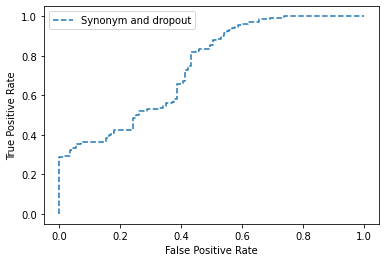

-----------------------------------------------------------------
finished


In [ ]:
from sklearn.model_selection import KFold
if __name__ == '__main__':
 
    lr=0.0001
    epochs=30
    batch_size= 64
    #for mean teacher 
    ratio =0.5
    alpha=0.99 #(0.90-0.99)
    maxlen=100
    n_split=10
    x_train, y_train, x_test, y_test, x_unlabel = loading_data()
    x_train, x_test, x_unlabel, vocab_size, tokenizer = tokenization(x_train,x_test, x_unlabel, maxlen)
    X = np.concatenate((x_train, x_test))
    Y = np.concatenate((y_train, y_test))
 
    
    for train_index,test_index in KFold(n_split).split(X):
        x_train,x_test=X[train_index],X[test_index]
        y_train,y_test=Y[train_index],Y[test_index]
        print("train Data_Size:",  np.shape(x_train))
        print("test Data_Size:",  np.shape(x_test))
        print('Train Label count: True, Fake', np.count_nonzero(y_train==1),np.count_nonzero(y_train==0))
        print('Test Label count : True, Fake', np.count_nonzero(y_test==1),np.count_nonzero(y_test==0))
        meanteacher=train_MeanTeacher(epochs, batch_size, alpha, lr, ratio,x_train, y_train, x_test, y_test, x_unlabel,vocab_size, tokenizer,maxlen)
        # model=train_supervised(epochs,batch_size,lr,x_train,y_train,x_test,y_test,maxlen,vocab_size)

        tf.keras.backend.clear_session()

    print('finished')